In [292]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import math
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import sklearn.datasets 
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split

# Definindo as funções que serão usadas

## Funções para calcular envoltória convexa

In [293]:
# Função para calcular a orientação dos pontos
def orientacao(p, q, r):
    val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])
    if val == 0:
        return 0  # Colinear
    return 1 if val > 0 else 2  # Horário ou anti-horário

# Função para encontrar o ponto mais baixo (e mais à esquerda)
def ponto_mais_baixo(pontos):
    o_ponto_mais_baixo = pontos[0]
    for ponto in pontos:
        if ponto[1] < o_ponto_mais_baixo[1] or (ponto[1] == o_ponto_mais_baixo[1] and ponto[0] < o_ponto_mais_baixo[0]):
            o_ponto_mais_baixo = ponto
    return o_ponto_mais_baixo

# Função para ordenar pontos angularmente a partir do ponto mais baixo
def ordenar_pontos_angularmente(pontos):
    o_ponto_mais_baixo = ponto_mais_baixo(pontos)
    return sorted(pontos, key=lambda ponto: (math.atan2(ponto[1] - o_ponto_mais_baixo[1], ponto[0] - o_ponto_mais_baixo[0]), ponto))

# Função para calcular a envoltória convexa
def envoltoria_convexa(pontos):
    n = len(pontos)
    if n < 3:
        return None  # Não é possível calcular a envoltória convexa com menos de 3 pontos

    pontos_ordenados = ordenar_pontos_angularmente(pontos)
    envoltoria = [pontos_ordenados[0], pontos_ordenados[1]]

    for i in range(2, n):
        while len(envoltoria) > 1 and orientacao(envoltoria[-2], envoltoria[-1], pontos_ordenados[i]) != 2:
            envoltoria.pop()
        envoltoria.append(pontos_ordenados[i])

    return envoltoria

## Funções para calcular overlap de envoltórias

In [294]:
# Função auxiliar para verificar se um ponto está em um segmento
def on_segment(p, q, r):
    if (
        min(p[0], r[0]) <= q[0] <= max(p[0], r[0])
        and min(p[1], r[1]) <= q[1] <= max(p[1], r[1])
    ):
        return True
    return False

# Função para verificar a interseção de segmentos
def do_intersect(p1, q1, p2, q2):
    # Encontre as orientações dos quatro pontos
    o1 = orientacao(p1, q1, p2)
    o2 = orientacao(p1, q1, q2)
    o3 = orientacao(p2, q2, p1)
    o4 = orientacao(p2, q2, q1)

    # Casos gerais
    if o1 != o2 and o3 != o4:
        return True

    # Casos especiais
    if o1 == 0 and on_segment(p1, p2, q1):
        return True
    if o2 == 0 and on_segment(p1, q2, q1):
        return True
    if o3 == 0 and on_segment(p2, p1, q2):
        return True
    if o4 == 0 and on_segment(p2, q1, q2):
        return True

    return False

# Função principal para verificar a sobreposição entre duas envoltórias convexas
def check_convex_hull_overlap(convex_hull1, convex_hull2):
    n1 = len(convex_hull1)
    n2 = len(convex_hull2)

    # Verifique se há interseção entre os segmentos de ambos os conjuntos de envoltória convexa
    for i in range(n1):
        for j in range(n2):
            if do_intersect(
                convex_hull1[i], convex_hull1[(i + 1) % n1],
                convex_hull2[j], convex_hull2[(j + 1) % n2]
            ):
                return True  # Há interseção

    return False  # Não há interseção

# Função para plotar uma envoltória convexa
def plot_envoltoria(pontos_envoltoria):

    env1 = envoltoria_convexa(pontos_envoltoria)
    x, y = zip(*pontos_envoltoria)
    env_x, env_y = zip(*env1)


    plt.scatter(x, y, c='b', marker='o', label='Pontos')
    plt.plot(env_x + (env_x[0],), env_y + (env_y[0],), linestyle='-', color='r', label='Envoltória Convexa')

## Funções para calcular linha perpendicular

In [295]:
def distancia(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def pontos_mais_proximos(conjunto1, conjunto2):
    min_dist = float('inf')
    pontos = None
    
    for p1 in conjunto1:
        for p2 in conjunto2:
            dist = distancia(p1, p2)
            if dist < min_dist:
                min_dist = dist
                pontos = (p1, p2)

    if pontos[0][1] > pontos[1][1]:
        acima = 0
    else:
        acima = 1
                
    return pontos[0], pontos[1], acima

def ponto_medio_reta(p1, p2):
    return ((p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2)

def reta_perpendicular_ponto_medio(p1, p2):
    ponto_medio = ponto_medio_reta(p1,p2)
    inclinacao = (p2[1] - p1[1]) / (p2[0] - p1[0])
    
    # Inclinação da reta perpendicular
    a_perpendicular = -1 / inclinacao
    
    # Calcula o coeficiente linear (b) da reta perpendicular
    b_perpendicular = ponto_medio[1] - a_perpendicular * ponto_medio[0]
    
    # Retorna a equação da reta perpendicular na forma ax + b
    return a_perpendicular, b_perpendicular

## Função para calcular o pca de uma df

In [296]:
def aplly_pca(df, target_name): #aqui o target tem que ser a string do nome da coluna rapaziada
    targets = df[target_name]
    df_numeric = df.select_dtypes(include=['number'])
    pca = PCA(n_components=2)
    df_pca = pca.fit_transform(df_numeric)
    df_pca = pd.DataFrame(df_pca, columns=['Componente 1', 'Componente 2'])

    explained_variance_ratio = pca.explained_variance_ratio_
    total_explained_variance = explained_variance_ratio.sum()
    print(f'Variação total explicada pelos dois primeiros componentes: {total_explained_variance * 100:.2f}%')

    #aqui to voltando os targets
    df_pca[target_name] = targets.reset_index(drop=True)

    df_pca = df_pca.rename(columns={target_name : 'class'})

    return df_pca

def plot_pca(df):
    sns.scatterplot(data=df, x='Componente 1', y='Componente 2', hue='class')

## Função para classificacao do modelo

In [297]:
def classificacao(df, a, b, acima):
    if acima == 0:
        abaixo = 1
    else:
        abaixo = 0

    df['guess'] = None
    classes = df['class'].unique()
    
    for index, row in df.iterrows():
        x, y = row['Componente 1'], row['Componente 2']
        valor_da_reta = a * x + b
        
        if y < valor_da_reta:
            df.at[index, 'guess'] = classes[acima]
        elif y > valor_da_reta:
            df.at[index, 'guess'] = classes[abaixo]
        else:
            print(f"Ponto {index} contido na reta")
            
    return df

## Função para calcular as métricas

In [298]:
#essa função também já plota para visualização
def metricas(df): # esse df aqui é o resultado do pca
    #separando as classes
    classes = df['class'].unique()


    proporcao_treinamento = 0.7
    proporcao_teste = 0.3

    # Divida o DataFrame em conjuntos de treinamento e teste
    dados_treinamento, dados_teste = train_test_split(df, test_size=proporcao_teste, random_state=42)

    df_class1 = dados_treinamento.loc[df['class'] == classes[0]]
    df_class2 = dados_treinamento.loc[df['class'] == classes[1]]


    #transformando cada df em pontos
    pontos1 = list(zip(df_class1['Componente 1'], df_class1['Componente 2']))
    pontos2 = list(zip(df_class2['Componente 1'], df_class2['Componente 2']))


    #pegando a envoltória de cada classe
    env1 = envoltoria_convexa(pontos1)
    env2 = envoltoria_convexa(pontos2)

    plot_envoltoria(pontos1)
    plot_envoltoria(pontos2)


    #checando se possuem interseccção
    interseccao = check_convex_hull_overlap(env1, env2)
    if(interseccao):
        print('Existe intersecção entre as envoltórias')
        return False

    #construindo o modelo
    p1, p2, acima = pontos_mais_proximos(env1, env2)
    a, b = reta_perpendicular_ponto_medio(p1, p2)    

    #construindo a df resultante
    resultado = classificacao(dados_teste, a, b, acima)

    
    precisao = precision_score(resultado['class'], resultado['guess'], pos_label=classes[0])
    revocacao = recall_score(resultado['class'], resultado['guess'], pos_label=classes[0])
    f1_escore = f1_score(resultado['class'], resultado['guess'], pos_label=classes[0])

    ##começando o plot

    ##normalizando o df para não ficar zoado o plot
    # scaler = StandardScaler()
    # df_scaled = resultado.copy()
    # df_scaled[['Componente 1', 'Componente 2']] = scaler.fit_transform(df[['Componente 1', 'Componente 2']])

    plt.figure(figsize=(8, 8))

    x_min, x_max = df['Componente 1'].min(), df['Componente 1'].max()

    # Usando esses valores para calcular os valores correspondentes de y na linha perpendicular
    x = np.linspace(x_min, x_max, 400)
    y = a * x + b

    # Plotando a linha perpendicular
    # ponto_inicial = [x_valor_inicial, y_valor_inicial]
    # ponto_final = [x_valor_final, y_valor_final]

    # Plotando a linha perpendicular
    # plt.plot([ponto_inicial[0], ponto_final[0]], [ponto_inicial[1], ponto_final[1]], color='g', linestyle='--', linewidth=2, label='Linha Perpendicular')

    
    env1_poly = plt.Polygon(env1, fill=None, edgecolor='r', label='Envoltória Convexa 1')
    env2_poly = plt.Polygon(env2, fill=None, edgecolor='b', label='Envoltória Convexa 2')
    plt.gca().add_patch(env1_poly)
    plt.gca().add_patch(env2_poly)
    
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color='k', linestyle='-', linewidth=2, label='Linha entre pontos mais próximos')
    
    x = np.linspace(min(df['Componente 1']), max(df['Componente 1']), 400)
    y = a * x + b
    plt.gca().set_aspect(0.5, adjustable='box')
    
    plt.legend()
    plt.grid(True)
    plt.show()

    print(precisao)
    return precisao, revocacao, f1_escore



# Fazendo as análises

## Dataset 1: Iris

In [299]:
iris = sns.load_dataset('iris')
iris = iris[iris['species'] != 'virginica']
iris_pca = aplly_pca(iris, "species")

Variação total explicada pelos dois primeiros componentes: 97.98%


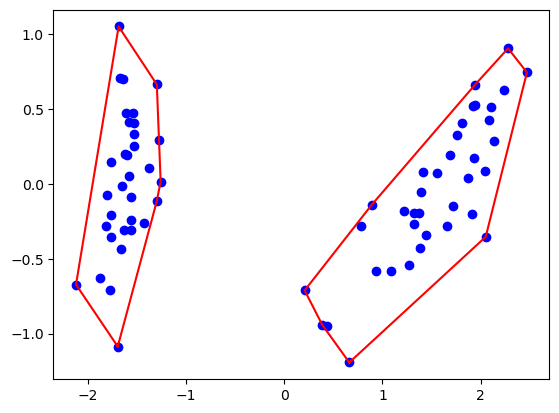

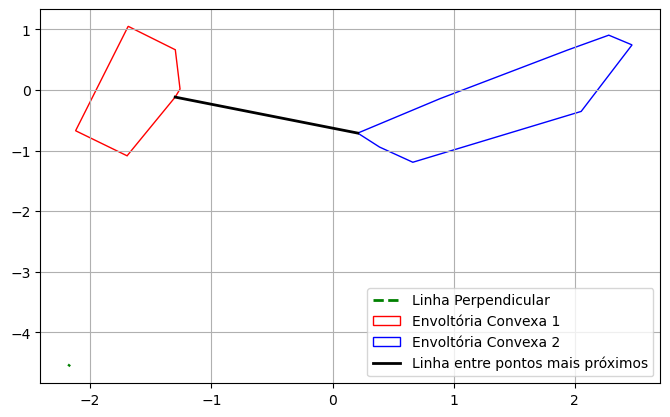

1.0
(1.0, 1.0, 1.0)


In [300]:
r = metricas(iris_pca)
print(r)

## Dataset 2: Pinguins

In [301]:
penguins = sns.load_dataset('penguins')
penguins = penguins.dropna()
penguins = penguins[penguins['species'] != 'Chinstrap']
penguins = penguins[penguins['sex'] != 'Female']
penguins_pca = aplly_pca(penguins, 'species')

Variação total explicada pelos dois primeiros componentes: 100.00%


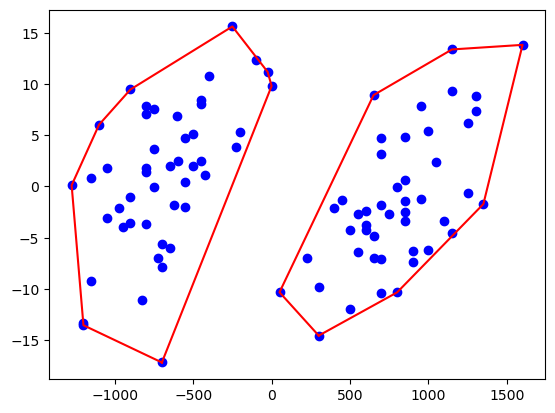

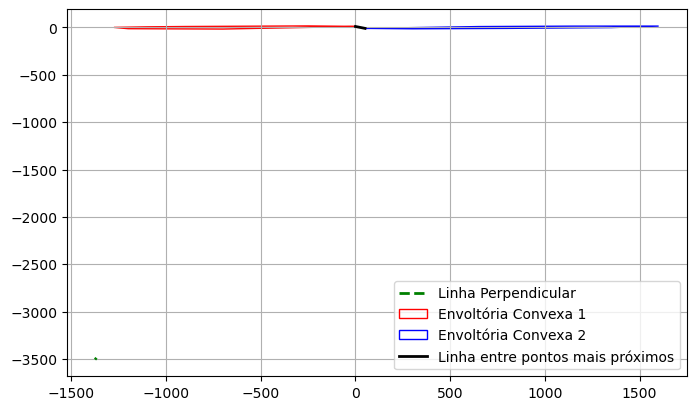

1.0


In [302]:
r = metricas(penguins_pca)

In [303]:
r

(1.0, 0.9615384615384616, 0.9803921568627451)